# Transformer Inference: PyTorch → ONNX → TensorRT (Performance Analysis)

**Objective:**

This notebook demonstrates how to optimize a transformer model (RoBERTa) by converting it from PyTorch to ONNX and then to TensorRT, achieving significant performance (inference speed) improvements.

We measure:
- **Latency per inference**
- **Relative speedup and Error Analaysis compared to PyTorch**

**What is TensorRT?**

TensorRT is NVIDIA's high-performance deep learning inference optimizer and runtime library. It optimizes trained neural networks by applying techniques like layer fusion, precision calibration (FP16/INT8), and kernel auto-tuning to dramatically reduce inference latency and memory usage on NVIDIA GPUs.

It's used in production environments where speed is critical - achieving 5-10x faster inference compared to standard frameworks like PyTorch or TensorFlow, making it ideal for real-time applications where milliseconds matter.

## Environment Setup

First, we install the necessary dependencies:

- **ONNX and ONNX Runtime:** For model conversion and GPU-accelerated inference
- **CUDA Python:** For CUDA operations
- **TensorRT:** NVIDIA's high-performance deep learning inference optimizer

N.B: We use TensorRT version 10.0.1, which is compatible with CUDA 12.4.

In [ ]:
!pip install onnx onnxruntime-gpu onnxscript cuda-python

In [ ]:
# Install complete TensorRT package
!pip install --extra-index-url https://pypi.nvidia.com tensorrt-cu12==10.0.1 tensorrt-cu12-bindings==10.0.1 tensorrt-cu12-libs==10.0.1


In [1]:
import torch
import onnx
import tensorrt as trt

print(f"PyTorch: {torch.__version__}")
print(f"PyTorch CUDA: {torch.version.cuda}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Onnx: {onnx.__version__}")
print("TensorRT version:", trt.__version__)

PyTorch: 2.9.0+cu126
PyTorch CUDA: 12.6
CUDA available: True
Onnx: 1.20.1
TensorRT version: 10.0.1


## Model Export Pipeline

We start with the roberta-base model from Hugging face's Transformers library. The model is loaded and moved to CUDA for GPU processing. Sample text is tokenized with:

- **Batch size:** 16 sentences
- **Max sequence length:** 32 tokens
- **Padding:** Applied to ensure uniform input shapes
- **Data type conversion:** Inputs are converted to int32 for TensorRT compatibility

Later, The PyTorch model is exported to ONNX format with:

- **Dynamic axes:** Allowing flexible batch sizes and sequence lengths
- **Input names:** input_ids and attention_mask
- **Output names:** logits (last hidden state) and other (pooler output)

In [ ]:
import time
import torch
from transformers import AutoTokenizer, AutoModel

# 1. Load model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().cuda()

# 2. Example batch of sentences
text = """ A good story encourages us to turn the next page and read more. We want to find out what happens next and what the main characters do and what they say to each other.
We may feel excited, sad, afraid, angry or really happy. This is because the experience of reading or listening to a story is much more likely to make us 'feel' that we are part
of the story, too. Just like in our 'real' lives, we might love or hate different characters in the story. Perhaps we recognise ourselves or others in some of them. Perhaps we
have similar problems. Because of this natural empathy with the characters, our brains process the reading of stories differently from the way we read factual information.
Our brains don't always recognise the difference between an imagined situation and a real one so the characters become 'alive' to us. What they say and do is therefore more meaningful.
This is why the words and structures that relate a story's events, descriptions and conversations are processed in this deeper way. In fact, cultures all around the world have always
used storytelling to pass knowledge from one generation to another. Our ancestors understood very well that this was the best way to make sure our histories and information about
how to relate to others and to our world was not only understood, but remembered too. (Notice that the word ‘history’ contains the word ‘story’ – More accurately, the word ‘story’
derives from ‘history’.) Encouraging your child to read or listen to stories should therefore help them to learn a second language in a way that is not only fun, but memorable.
Let's take a quick look at learning vocabulary within a factual text or within a story. Imagine the readers are eight-year-olds interested in animals. In your opinion, are they more
likely to remember AND want to continue reading the first or second text? """

texts = [item.strip() for item in text.split(".")][:16]  # adjust batch size here
inputs = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=32).to("cuda")

print("called tokenizer.")

# 3. Cast inputs to int32 for TensorRT
input_ids = inputs["input_ids"].to(torch.int32)
attention_mask = inputs["attention_mask"].to(torch.int32)

# 4: generate onnx file
torch.onnx.export(
    model.float(),
    (input_ids, attention_mask),
    "roberta.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits", "other"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "seq_len"},
        "attention_mask": {0: "batch_size", 1: "seq_len"},
        "logits": {0: "batch_size", 1: "seq_len"},
        "other":{0: "batch_size"}
    },
    opset_version=17
)

print("save to onnx file")

## TensorRT Engine Building

The ONNX model is converted to a TensorRT engine with the following optimizations:

Dynamic Shape Configuration:
- **Minimum shapes**: Batch=1, Sequence=32
- **Optimal shapes:** Batch=16, Sequence=32
- **Maximum shapes:** Batch=32, Sequence=32

Optimization Settings:
- **FP16 precision:** Enabled if the GPU supports it (2x faster with minimal accuracy loss)
- **Workspace memory:** 4GB allocated for optimization
- **Output:** Serialized TensorRT engine file (roberta.engine)

In [5]:
import numpy as np

def build_engine(onnx_file, engine_file):
    logger = trt.Logger(trt.Logger.WARNING)
    builder = trt.Builder(logger)
    network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
    parser = trt.OnnxParser(network, logger)

    # Parse ONNX
    with open(onnx_file, 'rb') as model:
        if not parser.parse(model.read()):
            print("ERROR: Failed to parse ONNX file")
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None

    # Builder config
    config = builder.create_builder_config()
    config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 4 << 30)  # 4GB

    # Enable FP16 if supported
    if builder.platform_has_fast_fp16:
        config.set_flag(trt.BuilderFlag.FP16)

    # Set dynamic shapes
    profile = builder.create_optimization_profile()
    profile.set_shape("input_ids", (1, 32), (16, 32), (32, 32))
    profile.set_shape("attention_mask", (1, 32), (16, 32), (32, 32))
    config.add_optimization_profile(profile)

    # Build engine
    print("Building TensorRT engine... This may take a while...")
    serialized_engine = builder.build_serialized_network(network, config)

    if serialized_engine is None:
        print("ERROR: Failed to build engine")
        return None

    # Save engine
    with open(engine_file, 'wb') as f:
        f.write(serialized_engine)

    print(f"Engine saved to {engine_file}")
    return serialized_engine

# Build your RoBERTa engine
build_engine('roberta.onnx', 'roberta.engine')

Building TensorRT engine... This may take a while...
Engine saved to roberta.engine


## Inference Comparison

We compare three inference methods, PyTorch (Baseline) x ONNX x TensorRT. 

In [6]:
# 1: load and tokenize inputs

import cuda
import sys
import time
import torch
from transformers import AutoTokenizer, AutoModel

# Load model & tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).eval().cuda()

# Example batch of sentences
text = """ A good story encourages us to turn the next page and read more. We want to find out what happens next and what the main characters do and what they say to each other.
We may feel excited, sad, afraid, angry or really happy. This is because the experience of reading or listening to a story is much more likely to make us 'feel' that we are part
of the story, too. Just like in our 'real' lives, we might love or hate different characters in the story. Perhaps we recognise ourselves or others in some of them. Perhaps we
have similar problems. Because of this natural empathy with the characters, our brains process the reading of stories differently from the way we read factual information.
Our brains don't always recognise the difference between an imagined situation and a real one so the characters become 'alive' to us. What they say and do is therefore more meaningful.
This is why the words and structures that relate a story's events, descriptions and conversations are processed in this deeper way. In fact, cultures all around the world have always
used storytelling to pass knowledge from one generation to another. Our ancestors understood very well that this was the best way to make sure our histories and information about
how to relate to others and to our world was not only understood, but remembered too. (Notice that the word 'history' contains the word 'story' – More accurately, the word 'story'
derives from 'history'.) Encouraging your child to read or listen to stories should therefore help them to learn a second language in a way that is not only fun, but memorable.
Let's take a quick look at learning vocabulary within a factual text or within a story. Imagine the readers are eight-year-olds interested in animals. In your opinion, are they more
likely to remember AND want to continue reading the first or second text? """

texts = [item.strip() for item in text.split(".")][:16]  # adjust batch size here
inputs = tokenizer(texts, return_tensors="pt", padding="max_length", truncation=True, max_length=32).to("cuda")
print("finish processing input and tokenizer.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


finish processing input and tokenizer.


### Baseline (PyTorch) Inference

In [26]:
# 2. Baseline PyTorch inference

print("**********Pytorch Result*************")
with torch.no_grad():
    start = time.time()
    outputs = model(**inputs)
    torch.cuda.synchronize()
    end = time.time()
    baseline_time = end - start
    print(f"PyTorch latency -----> {baseline_time:.4f} sec/n")
print("Output shape (PyTorch):", outputs.last_hidden_state.shape)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
output_logits = outputs.last_hidden_state
pytorch_base_tensor = outputs.last_hidden_state.cpu().numpy()

**********Pytorch Result*************
PyTorch latency -----> 0.0585 sec/n
Output shape (PyTorch): torch.Size([16, 32, 768])


### ONNX Inference

In [27]:
# 3. Onnx inference

import onnxruntime as ort

print("*******ONNX Result**********")
sess = ort.InferenceSession(
    "roberta.onnx",
    providers=["CUDAExecutionProvider"]
)

input_ids_np = inputs["input_ids"].to(torch.int32).cpu().numpy()
attention_mask_np = inputs["attention_mask"].to(torch.int32).cpu().numpy()

onnx_inputs = {"input_ids": input_ids_np, "attention_mask": attention_mask_np}
start = time.time()
onnx_outputs = sess.run(None, onnx_inputs)
end = time.time()
onnx_time = end - start
print(f"Onnx latency -----> {onnx_time:.4f} sec")

*******ONNX Result**********
Onnx latency -----> 0.0440 sec


### Comparison: Baseline (PyTorch) vs ONNX

In [28]:
# 4: Compare pytorch baseline output and onnx output

onnx_tensor = onnx_outputs[0]
diff = np.abs(pytorch_base_tensor - onnx_tensor)
diff_mean = diff.mean()
diff_max = diff.max()
diff_percent = (diff > 0.1).mean() * 100
print("pytorch baseline vs. onnx output:")
print("Mean absolute difference:", diff_mean)
print("Max absolute difference:", diff_max)
print("Percentage of values with diff > 0.1:", diff_percent, "%")

pytorch baseline vs. onnx output:
Mean absolute difference: 2.2788453e-07
Max absolute difference: 1.04904175e-05
Percentage of values with diff > 0.1: 0.0 %


### Load TRT Engine and Run Inference

In [19]:
# 5: Load TRT engine

ENGINE_PATH = "roberta.engine"
logger = trt.Logger(trt.Logger.WARNING)

with open(ENGINE_PATH, "rb") as f:
    engine_bytes = f.read()

runtime = trt.Runtime(logger)
trt_engine = runtime.deserialize_cuda_engine(engine_bytes)
assert trt_engine is not None, "Failed to load engine"

context = trt_engine.create_execution_context()
assert context is not None, "Failed to create execution context"

# Check context
if context is None:
    raise RuntimeError("Could not create TensorRT context")
print("TensorRT engine loaded")

TensorRT engine loaded


**Something very important:**

- All parameter specifications must remain consistent from ONNX export through TensorRT inference. When you build a TensorRT engine from an ONNX model, the engine inherits and locks in all the parameter information—input/output names, data types, and shape constraints—directly from the ONNX file.

- TensorRT engines enforce strict type and shape matching. Unlike flexible frameworks like PyTorch, TensorRT requires exact alignment: the batch size must fall within the defined min/max range, sequence lengths must match the configured dynamic axes, and data types (int32, float32, etc.) must be identical to what was specified during ONNX export. Any mismatch will cause the engine to fail at runtime.

- Always validate your inference inputs against both the ONNX model and the built engine. Before running TensorRT inference, verify that your tokenized inputs have the correct shape ranges and data types by inspecting both the original ONNX model specification and the TensorRT engine's tensor metadata. This cross-check prevents hard-to-debug runtime errors and ensures your optimized pipeline works correctly.

In [20]:
# 6: prepare for tensorrt inference

# Convert to PyTorch tensor, specify input tensor shape and address
input_ids_t = input_ids.detach().to(device='cuda', dtype=torch.int32)
attention_mask_t = attention_mask.detach().to(device='cuda', dtype=torch.int32)
context.set_input_shape("input_ids", tuple(input_ids_t.shape))
context.set_input_shape("attention_mask", tuple(attention_mask_t.shape))
context.set_tensor_address("input_ids", int(input_ids_t.data_ptr()))
context.set_tensor_address("attention_mask", int(attention_mask_t.data_ptr()))

# Now query output shapes and specify output shape and address
logits_shape = context.get_tensor_shape("logits")
other_shape = context.get_tensor_shape("other")

logits_t = torch.empty(output_logits.shape, device='cuda', dtype=torch.float32)
context.set_tensor_address("logits", int(logits_t.data_ptr()))
other_shape = tuple([output_logits.shape[0], output_logits.shape[2]])
other_t = torch.empty(other_shape, device='cuda', dtype=torch.float32)
context.set_tensor_address("other", int(other_t.data_ptr()))

True

In [21]:
# 7. Execute tensorRT inference

print("*******TensorRT Result**********")
stream = torch.cuda.Stream()
start=time.time()
with torch.cuda.stream(stream):
    context.execute_async_v3(
        stream_handle=stream.cuda_stream
    )
# Synchronize only when you need outputs
stream.synchronize()
end = time.time()
trt_time = end - start
print(f"tensorRT latency -----> {trt_time:.4f} sec")

*******TensorRT Result**********
tensorRT latency -----> 0.0082 sec


### Comparison: Baseline (PyTorch) x TensorRT

In [29]:
# 8. Compare pytorch baseline with tensorRT inference result

output_tensorrt_np = logits_t.cpu().numpy()
diff = np.abs(pytorch_base_tensor - output_tensorrt_np)
diff_mean = diff.mean()
diff_max = diff.max()
diff_percent = (diff > 0.1).mean() * 100

print("Pytorch baseline vs tensorRT output:")
print("Mean absolute difference:", diff_mean)
print("Max absolute difference:", diff_max)
print("Percentage of values with diff > 0.1:", diff_percent, "%")

Pytorch baseline vs tensorRT output:
Mean absolute difference: 0.00094214646
Max absolute difference: 0.07605171
Percentage of values with diff > 0.1: 0.0 %


## Overall Comparison & Analysis

The notebook validates the optimized models by:

1. **Accuracy Comparison:** Computing absolute differences between outputs
    - PyTorch vs ONNX: Mean diff ~2.3e-7 (excellent)
    - PyTorch vs TensorRT: Mean diff ~0.0009 (acceptable for FP16)
2. **Performance Metrics:** Measuring inference latency for each method
3. **Visualization:** Bar chart showing speedup comparisons

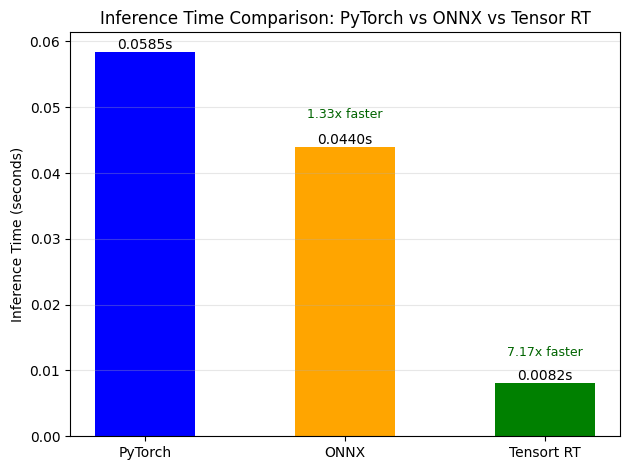

In [33]:
import matplotlib.pyplot as plt

inference_time = [baseline_time, onnx_time, trt_time]
labels = ['PyTorch', 'ONNX', 'Tensort RT']

# Create bar chart
bars = plt.bar(labels, inference_time, width=0.5, color=['blue', 'orange', 'green'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}s',
             ha='center', va='bottom', fontsize=10)

# Add speedup annotations
speedup_onnx = baseline_time / onnx_time
speedup_trt = baseline_time / trt_time
plt.text(1, onnx_time * 1.1, f'{speedup_onnx:.2f}x faster',
         ha='center', fontsize=9, color='darkgreen')
plt.text(2, trt_time * 1.5, f'{speedup_trt:.2f}x faster',
         ha='center', fontsize=9, color='darkgreen')

plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: PyTorch vs ONNX vs Tensor RT')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Observations:**

The ONNX conversion achieves near-perfect accuracy with negligible differences (mean: 2.3e-07), confirming a lossless transformation from PyTorch. The TensorRT engine introduces slightly larger deviations (mean: 0.0009, max: 0.076) due to FP16 precision optimizations, but with zero values exceeding 0.1 difference. This represents an ideal optimization outcome—achieving dramatic 7x speedup while preserving model quality well.

- **PyTorch:** 0.0585 seconds (baseline)
- **ONNX:** 0.0440 seconds (~1.33x faster)
- **TensorRT:** 0.0082 seconds (~7.13x faster)